---
author: Zeel B Patel
badges: true
categories:
  - ML
  - CV
date: "2024-12-29"
description: Basic operations in object detection task
title: Object Detection - A how-to guide
toc: true
---


# Imports


In [1]:
# Config
import os

# Basic
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

# Monitoring
from tqdm.notebook import tqdm

# IO
from os.path import join, exists, basename, dirname, splitext, expanduser
from glob import glob

# Parallel processing
from joblib import Parallel, delayed

import yaml
from PIL import Image
import supervision as sv
import cv2
from supervision.utils.file import list_files_with_extensions, read_txt_file
from supervision.detection.utils import polygon_to_xyxy
from ultralytics import YOLO
from ultralytics.utils.downloads import download
from pathlib import Path
from inference.models.utils import get_roboflow_model
from roboflow import Roboflow
from typing import List, Tuple
from dotenv import load_dotenv
load_dotenv()

%reload_ext memory_profiler

sv.__version__

'0.25.1'

# Axis-Aligned Bounding Boxes (AABB)

## Dataset

### Download

In [2]:
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
ws = rf.workspace("plan-zkend")
project = ws.project("animals-ksxhf-plgrl")
version = project.version(2)
rf_dataset = version.download("yolov8", location="/tmp/tmp", overwrite=True)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /tmp/tmp in yolov8:: 100%|██████████| 212/212 [00:00<00:00, 5963.05it/s]


In [3]:
rf_dataset.location

'/tmp/tmp'

In [4]:
!ls -lh {rf_dataset.location}

total 24K
-rw-rw-r-- 1 patel_zeel patel_zeel  423 Feb  3 11:40 data.yaml
-rw-rw-r-- 1 patel_zeel patel_zeel  141 Feb  3 11:40 README.dataset.txt
-rw-rw-r-- 1 patel_zeel patel_zeel  896 Feb  3 11:40 README.roboflow.txt
drwxrwxr-x 4 patel_zeel patel_zeel 4.0K Jan 17 18:47 test
drwxrwxr-x 4 patel_zeel patel_zeel 4.0K Jan 17 18:47 train
drwxrwxr-x 4 patel_zeel patel_zeel 4.0K Jan 17 22:52 valid


In [5]:
!ls -lh {rf_dataset.location}/test

total 8.0K
drwxrwxr-x 2 patel_zeel patel_zeel 4.0K Jan 17 18:47 images
drwxrwxr-x 2 patel_zeel patel_zeel 4.0K Jan 17 18:47 labels


In [6]:
!ls -l {rf_dataset.location}/test/images/*.jpg | wc -l

7


In [7]:
!ls -l {rf_dataset.location}/test/labels/*.txt | wc -l

7


#### Check a sample manually

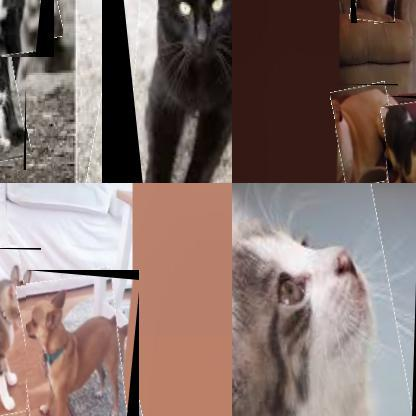

In [8]:
image_paths = glob(f"{rf_dataset.location}/test/images/*.jpg")
sample_image_path = image_paths[0]
sample_image = Image.open(sample_image_path)
sample_image

In [9]:
label_paths = glob(f"{rf_dataset.location}/test/labels/*.txt")
sample_label_path = label_paths[0]
sample_label = np.loadtxt(sample_label_path, ndmin=2)
sample_label.shape

(1, 5)

In [10]:
sample_label

array([[         18,     0.67217,     0.47797,     0.53625,     0.51148]])

### Load with supervision

In [ ]:
%%time

dataset = sv.DetectionDataset.from_yolo(images_directory_path=f"{rf_dataset.location}/test/images", annotations_directory_path=f"{rf_dataset.location}/test/labels", data_yaml_path=f"{rf_dataset.location}/data.yaml")
len(dataset)

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 10.6 ms


7

### Visualize

Ideally, `LabelAnnotator` should show the class names on top of the bounding boxes but currently it shows class IDs. This issue is tracked [here](https://github.com/roboflow/supervision/issues/1772).

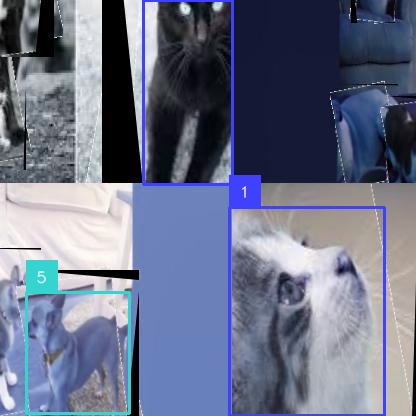

In [12]:
image_path, image, detection = dataset[0]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_frame = box_annotator.annotate(image.copy(), detection)
annotated_frame = label_annotator.annotate(annotated_frame.copy(), detection)

Image.fromarray(annotated_frame)

A quick fix for now.

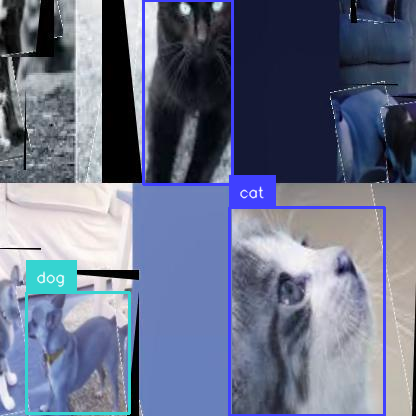

In [13]:
image_path, image, detection = dataset[0]
np_classes = np.array(dataset.classes)
detection.data['class_name'] = np_classes[detection.class_id]
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_frame = box_annotator.annotate(image.copy(), detection)
annotated_frame = label_annotator.annotate(annotated_frame.copy(), detection)

Image.fromarray(annotated_frame)

## Inference

### With roboflow models

Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'TensorrtExecutionProvider, CUDAExecutionProvider, CPUExecutionProvider'
Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'TensorrtExecutionProvider, CUDAExecutionProvider, CPUExecutionProvider'
2025-02-03 11:42:55.119414030 [E:onnxruntime:Default, provider_bridge_ort.cc:1862 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1539 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcudnn_adv.so.9: cannot open shared object file: No such file or directory

2025-02-03 11:42:55.119453180 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:993 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned

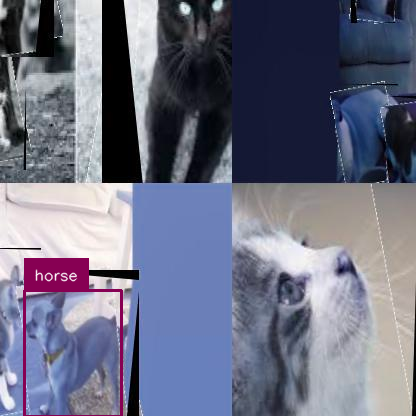

In [14]:
rf_model = get_roboflow_model("yolov8s-640")
prediction = rf_model.infer(image)[0]
detection = sv.Detections.from_inference(prediction)
annotated_image = box_annotator.annotate(image.copy(), detection)
annotated_image = label_annotator.annotate(annotated_image, detection)
Image.fromarray(annotated_image)

### With ultralytics models


0: 640x640 1 dog, 2 horses, 1 sheep, 1 cow, 6.3ms
Speed: 10.2ms preprocess, 6.3ms inference, 274.3ms postprocess per image at shape (1, 3, 640, 640)


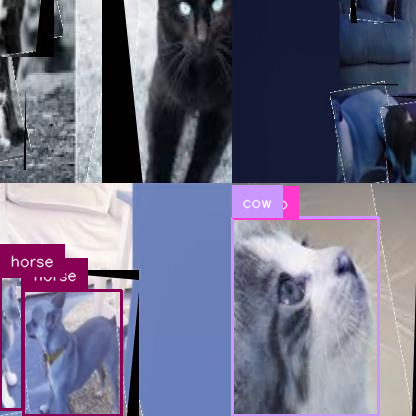

In [15]:
model = YOLO("yolov8s")
prediction = model(image)[0]
detection = sv.Detections.from_ultralytics(prediction)
annotated_image = box_annotator.annotate(image.copy(), detection)
annotated_image = label_annotator.annotate(annotated_image, detection)
Image.fromarray(annotated_image)

## Metrics

In [16]:
model = YOLO("yolov8x")
targets = []
predictions = []
np_classes = np.array(dataset.classes)
for image_path, image, target in tqdm(dataset):
    # add class names to detection
    # target.data['class_name'] = np_classes[target.class_id]

    # remove classes not in model
    # target = target[np.isin(target['class_name'], list(model.names.values()))]
    # if len(target) == 0:
    #     print(f"Skipping {image_path} as it has no classes in model")
    #     continue
    
    prediction = model(image, verbose=False)[0]
    detection = sv.Detections.from_ultralytics(prediction)
    
    # remove classes not in dataset
    detection = detection[np.isin(detection['class_name'], dataset.classes)]
    
    # remap class ids
    detection.class_id = np.array([dataset.classes.index(class_name) for class_name in detection['class_name']])
    
    targets.append(target)
    predictions.append(detection)

  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
mAP = sv.metrics.MeanAveragePrecision().update(predictions, targets).compute()
mAP50 = mAP.mAP_scores[0]
mAP5095 = mAP.mAP_scores.mean()
print(f"mAP50: {mAP50:.2f}, mAP50-95: {mAP5095:.2f}")

mAP50: 0.29, mAP50-95: 0.19


# Oriented Bounding Boxes (OBB)

## Dataset


### Download


In [3]:
if not exists('/tmp/DOTAv1.zip'):
    # Downloaded in 4m 5s with 6.09 MB/s
    !wget https://github.com/ultralytics/assets/releases/download/v0.0.0/DOTAv1.zip -O /tmp/DOTAv1.zip
else:
    print('DOTAv1.zip already downloaded')
    
if not exists('/tmp/DOTAv1'):
    !unzip /tmp/DOTAv1.zip -d /tmp
else:
    print('DOTAv1 already unzipped')

DOTAv1.zip already downloaded
DOTAv1 already unzipped


In [4]:
!ls /tmp/DOTAv1

21.84s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


images	labels


In [5]:
!ls /tmp/DOTAv1/images

27.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


test  train  val


In [6]:
print(f"Number of train samples: {len(glob('/tmp/DOTAv1/images/train/*.jpg'))}")
print(f"Number of val samples: {len(glob('/tmp/DOTAv1/images/val/*.jpg'))}")

Number of train samples: 1411
Number of val samples: 458


Keep 20 samples in each and delete the rest


In [7]:
paths = {'images': {}, 'labels': {}}

for split in ['train', 'val']:
    paths['images'][split] = glob(f"/tmp/DOTAv1/images/{split}/*.jpg")[:100]
    paths['labels'][split] = [p.replace("images", "labels").replace(".jpg", ".txt") for p in paths['images'][split]]
    !mkdir -p /tmp/DOTAv1_small/images/{split}
    !mkdir -p /tmp/DOTAv1_small/labels/{split}

    for img, label in tqdm(zip(paths['images'][split], paths['labels'][split])):
        os.system(f"cp {img} /tmp/DOTAv1_small/images/{split}/")
        os.system(f"cp {label} /tmp/DOTAv1_small/labels/{split}/")

32.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
38.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


0it [00:00, ?it/s]

44.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
49.55s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


0it [00:00, ?it/s]

In [8]:
print(f"Number of train samples: {len(glob('/tmp/DOTAv1_small/images/train/*.jpg'))}")
print(f"Number of val samples: {len(glob('/tmp/DOTAv1_small/images/val/*.jpg'))}")

Number of train samples: 100
Number of val samples: 100


### Check a sample


In [9]:
train_images = glob("/tmp/DOTAv1_small/images/train/*.jpg")
sample_image_path = train_images[1]
sample_image_path

'/tmp/DOTAv1_small/images/train/P2732.jpg'

In [10]:
sample_image = Image.open(sample_image_path)
sample_image.size

(3087, 2632)

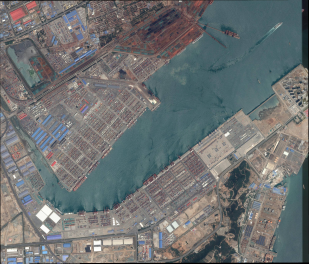

In [11]:
sample_image.reduce(10)

In [12]:
sample_label_path = sample_image_path.replace("images", "labels").replace(".jpg", ".txt")
assert exists(sample_label_path), f"Error: {sample_label_path} does not exist"

In [13]:
sample_label = np.loadtxt(sample_label_path, ndmin=2)
sample_label.shape

(51, 9)

In [14]:
sample_label[0]

array([          7,     0.72076,     0.45023,     0.72238,     0.44871,     0.73178,     0.46087,     0.73016,     0.46201])

The above is YOLO-Oriented Bounding Box (OBB) format: class_id, x1, y1, x2, y2, x3, y3, x4, y4


### Load with supervision


supervision does not support DOTA dataset yet, but ultralytics has already converted it to YOLO format. Let's create data.yml file for DOTA dataset.


In [15]:
%%writefile /tmp/DOTAv1_small/data.yml
train: /tmp/DOTAv1_small/images/train
val: /tmp/DOTAv1_small/images/val
test: /tmp/DOTAv1_small/images/test
nc: 15
names: ['plane', 'ship', 'storage tank', 'baseball diamond', 'tennis court', 'basketball court', 'ground track field', 'harbor', 'bridge', 'large vehicle', 'small vehicle', 'helicopter', 'roundabout', 'soccer ball field', 'swimming pool']

Overwriting /tmp/DOTAv1_small/data.yml


In [17]:
# %%memit

dataset = sv.DetectionDataset.from_yolo(
    "/tmp/DOTAv1_small/images/train",
    "/tmp/DOTAv1_small/labels/train",
    data_yaml_path="/tmp/DOTAv1_small/data.yml",
    is_obb=True,
)

### Visualize


(np.float64(-0.5), np.float64(610.5), np.float64(0.0), np.float64(305.0))

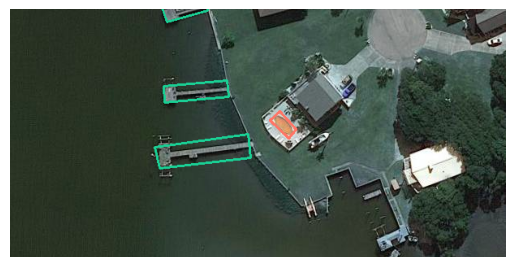

In [17]:
sample = dataset[0]
img_array = sample[1]
img_detections = sample[2]

annotator = sv.OrientedBoxAnnotator()
annotated_img = annotator.annotate(img_array, img_detections)

plt.imshow(annotated_img)
plt.ylim(0, annotated_img.shape[1] // 2)
plt.axis("off")

## Inference


- iou = Non-max suppression IOU threshold
- conf = Object confidence threshold


### Inline method


In [18]:
model = YOLO("yolo11x-obb")

detections = []
predictions = []
for img_path, img, detection in tqdm(dataset):
    prediction = model(img, imgsz=1024, iou=0.33, max_det=300, conf=0.001, verbose=False)[0]
    predictions.append(sv.Detections.from_ultralytics(prediction))
    detections.append(detection)

  0%|          | 0/20 [00:00<?, ?it/s]

### CLI method


In [19]:
!cd /tmp && yolo obb predict model=yolo11x-obb source=/tmp/DOTAv1_small/images/val exist_ok=True save=False save_txt=True imgsz=1024 iou=0.33 max_det=300 conf=0.001 verbose=False

Ultralytics 8.3.55 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA A100-SXM4-80GB, 81156MiB)
YOLO11x-obb summary (fused): 483 layers, 58,752,928 parameters, 0 gradients, 202.8 GFLOPs
Results saved to runs/obb/predict
20 labels saved to runs/obb/predict/labels
💡 Learn more at https://docs.ultralytics.com/modes/predict


## Metrics


### Inline method


#### Confusion matrix


> At the time of writing this post, supervision's ConfusionMatrix does not support OBB. Follow [this issue](https://github.com/roboflow/supervision/issues/1760) for updates.


- conf_threshold -- minimum confidence threshold for a detection to be considered. Instances with confidence below this threshold are ignored as if they were not predicted.
- iou_threshold -- minimum intersection over union (IoU) threshold for a detection to be considered a true positive. Predictions with IoU below this threshold are considered false positives.


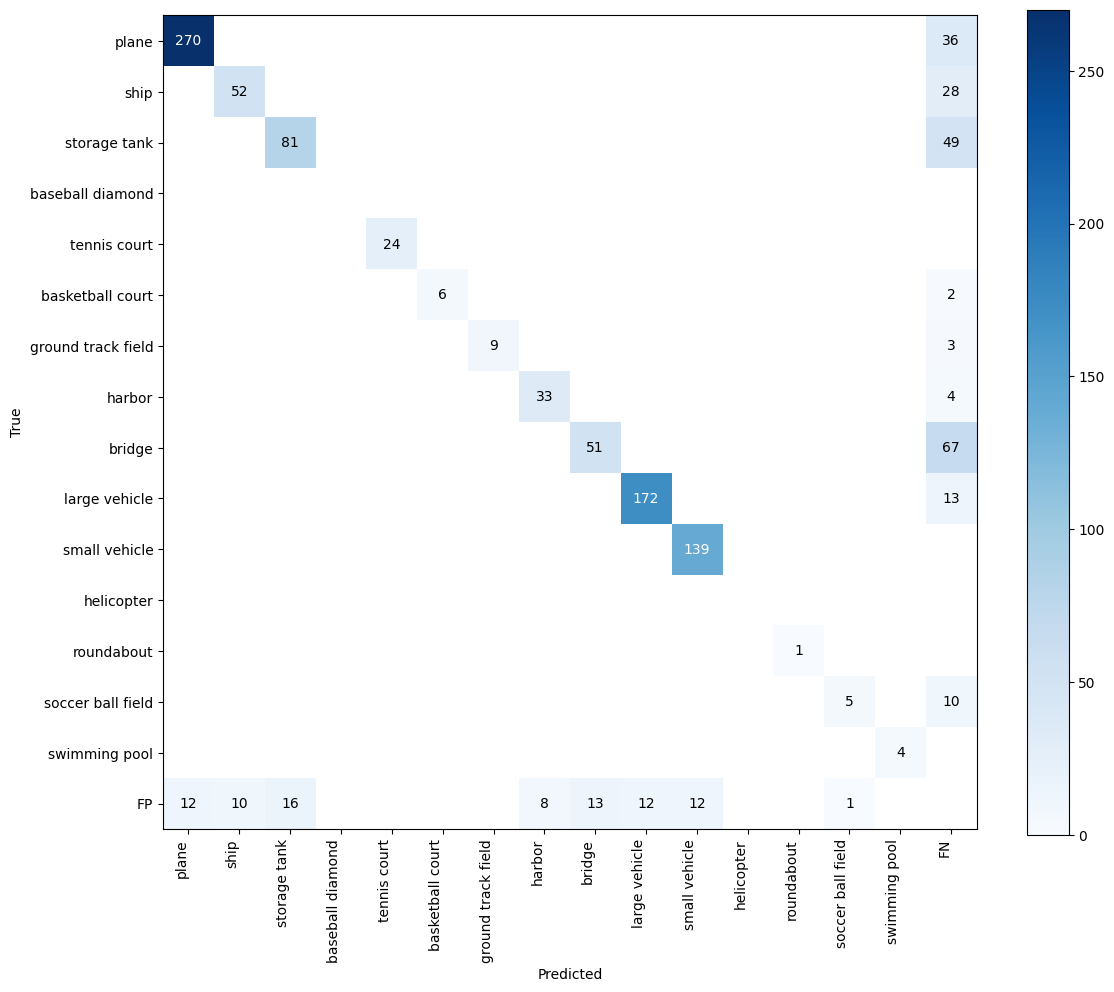

In [47]:
cm = sv.ConfusionMatrix.from_detections(
    predictions, detections, classes=dataset.classes, conf_threshold=0.25, iou_threshold=0.33
)
_ = cm.plot()

#### Precision, Recall & F1 Score


You know the formulas of Precision and Recall.

```
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
```

We can also write them as the following:

```
Precision = TP / PP
Recall = TP / AP
```

where `PP` is the number of predicted positives and `AP` is the number of actual positives.


To calculate `TP`, we can sum the values along the diagonal of the confusion matrix.


In [48]:
TP = cm.matrix.diagonal().sum()
TP

np.float64(847.0)

To calculate `PP`, we should remove all cells which represent "not predicted" instances. That is nothing but `FN`. Thus, we will remove the last column representing `FN`.


In [49]:
PP = cm.matrix[:, :-1].sum()
PP

np.float64(931.0)

To calculate `AP`, we should remove all cells which represent "predicted but wrong" instances. That is nothing but `FP`. Thus, we will remove the last row representing `FP`.


In [50]:
AP = cm.matrix[:-1, :].sum()
AP

np.float64(1059.0)

In [51]:
P = TP / PP
R = TP / AP
F1 = 2 * P * R / (P + R)
print(f"P: {P:.2f}, R: {R:.2f}, F1: {F1:.2f}")

P: 0.91, R: 0.80, F1: 0.85


Notice that to compute `P`, `R` and `F1`, we need to fix a confidence threshold and an IOU threshold. Now, we will see some metrics which integrate over confidence thresholds and use only IoU threshold.


There are specific methods in `supervision` to compute Precision, Recall and F1 Score, but they are significantly slow. If they become faster in future, one can use them with the following code.


In [52]:
# f1_score = sv.metrics.MeanAveragePrecision(sv.metrics.MetricTarget.ORIENTED_BOUNDING_BOXES)
# f1_score.update(predictions, detections).compute()

In [54]:
# precision = sv.metrics.Precision(sv.metrics.MetricTarget.ORIENTED_BOUNDING_BOXES)
# precision.update(predictions, detections).compute()

In [55]:
# recall = sv.metrics.Recall(sv.metrics.MetricTarget.ORIENTED_BOUNDING_BOXES)
# recall.update(predictions, detections).compute()

### CLI method


When we use CLI method of inference in Ultralytics, results are saved on the disk. Now, we need to load them back to calculate metrics.


In [58]:
from ultralytics.engine.results import Results

The following method is extremely space consuming unless the following issue is resolved: https://github.com/roboflow/supervision/issues/1762. Not adding further steps until the issue is resolved but the steps should be similar to the axis-aligned bounding box case.

In [78]:
predicted_dataset = sv.DetectionDataset.from_yolo(
    "/tmp/DOTAv1_small/images/val",
    "/tmp/runs/obb/predict/labels",
    data_yaml_path="/tmp/DOTAv1_small/data.yml",
    is_obb=True,
)

KeyboardInterrupt: 

# Versions


In [25]:
%reload_ext watermark

%watermark -v -m -p supervision,ultralytics

Python implementation: CPython
Python version       : 3.10.15
IPython version      : 8.28.0

supervision: 0.26.0rc1
ultralytics: 8.3.55

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 5.15.0-124-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

